In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append('./../../../designer/script/')
sys.path.append('./../../')
sys.path.append('./../../../')

import pickle
import copy

from analyze_utils.make_design import get_edge_filter_design, get_minus_filter_spec
from analyze_utils.color import cold_qualitative, qualitative



In [2]:


from design import BaseDesign
from film import TwoMaterialFilm
from spectrum import Spectrum
from optimizer.adam import AdamThicknessOptimizer
from optimizer.needle_insert import make_test_insert_film, get_insert_grad

# plot insert grad
def plot_insert_gradient(film, target_spec, search_pts=200, return_grad=False, plot=True):
    film = copy.deepcopy(film)
    insert_idx = make_test_insert_film(film, search_pts)
    grad = get_insert_grad(film, [target_spec])
    
    # determine best insertion position
    i_best = np.argmax(-grad[insert_idx])
    best_insert = film.get_d()[:insert_idx[i_best]].sum()
    print(f'best insertion is at: {best_insert} nm')
    if plot:
        fig, ax = plt.subplots(1, 1)
        ax.plot([film.get_d()[:i].sum() for i in insert_idx], grad[insert_idx])
        ax.plot([0, film.get_d().sum()], [0, 0], c='grey', alpha=0.5, label='zero')
        ax.set_xlabel('position from surface / nm')
        ax.set_ylabel('insert gradient')
        ax.legend()

    if return_grad:
        return [film.get_d()[:i].sum() for i in insert_idx], grad[insert_idx], best_insert
    else:
        return best_insert




In [7]:
def generate_data_small(search_range_d1, search_range_d2):
    wls = np.linspace(400, 700, 20, dtype=float)
    # target_spec = Spectrum(0., wls, np.ones(wls.shape[0], dtype='float'))
    target_spec = get_minus_filter_spec(wls)

    init_d = np.array([1000], dtype='float')
    init_film = TwoMaterialFilm('SiO2', 'TiO2', 'SiO2', init_d)
    design = BaseDesign([target_spec], init_film)

    # mimic after needle insertion
    optimizer = AdamThicknessOptimizer(design.film, [target_spec], max_steps=200, record=True)
    optimizer.optimize()
    d = design.film.get_d()
    TiO2_thickness = plot_insert_gradient(design.film, target_spec, plot=False)
    d = np.array([TiO2_thickness, 0])
    design.film.update_d(d)
    optimizer_aft = AdamThicknessOptimizer(design.film, [target_spec], max_steps=200, record=True)
    optimizer_aft.optimize()

    print(f'number of layers: {design.film.get_layer_number()}, should be 2.')
    d1_opt, d2_opt = design.film.get_d()[: 2]

    # process record: show optimization track
    films, _ = optimizer._rearrange_record()
    films_aft, _ = optimizer_aft._rearrange_record()
    films += films_aft
    track_x = np.array([film.get_d()[0] for film in films])
    track_y = np.array([film.get_d()[1] if film.get_d().shape[0] > 1 else 0 for film in films])

    # plot loss landscape
    loss_arr = np.empty((search_range_d1.shape[0], search_range_d2.shape[0]))
    for i, d1 in enumerate(search_range_d1):
        for j, d2 in enumerate(search_range_d2):
            d = design.film.get_d()
            d[0] = d1
            d[1] = d2
            design.film.update_d(d)
            loss_arr[i, j] = design.calculate_loss()

    return loss_arr, track_x, track_y


def plot_small_range(ax, reuse_saved=False):
    
    search_range_d1 = np.linspace(300, 400, 40)
    search_range_d2 = np.linspace(0, 100, 40)

    if reuse_saved:
        loss_arr = np.load('./small_loss_arr.npy')
        track_x = np.load('./track_x.npy')
        track_y = np.load('./track_y.npy')
    else:
        loss_arr, track_x, track_y = generate_data_small(search_range_d1, search_range_d2)
        # save result
        np.save('./small_loss_arr', loss_arr)

    # plot
    ax.plot(track_y + 1 * (track_y == 0), track_x, color='#A60628', linewidth='4', ls='-')
    s = ax.imshow(
        (loss_arr),
        aspect = 2, 
        extent = [
            search_range_d2[0], 
            search_range_d2[-1], 
            search_range_d1[-1], 
            search_range_d1[0]
        ], 
        vmin = 0.23, 
        vmax = 0.4
    )

    ax.set_xlabel('$d_2$' + ' / nm')
    ax.set_ylabel('$d_1$' + ' / nm')
    ax.grid(visible=False)

    return s


In [3]:
def generate_data_large(search_range_d1, search_range_d2):
    wls = np.linspace(400, 700, 20, dtype=float)
    # target_spec = Spectrum(0., wls, np.ones(wls.shape[0], dtype='float'))
    target_spec = get_minus_filter_spec(wls)

    init_d = np.array([1000], dtype='float')
    init_film = TwoMaterialFilm('SiO2', 'TiO2', 'SiO2', init_d)
    design = BaseDesign([target_spec], init_film)

    # mimic after needle insertion
    optimizer = AdamThicknessOptimizer(design.film, [target_spec], max_steps=200, record=True)
    optimizer.optimize()
    d = design.film.get_d()
    grad_x, grad_y, TiO2_thickness = plot_insert_gradient(design.film, target_spec, plot=False, return_grad=True)
    d = np.array([TiO2_thickness, 0])
    design.film.update_d(d)
    optimizer_aft = AdamThicknessOptimizer(design.film, [target_spec], max_steps=200, record=True)
    optimizer_aft.optimize()

    print(f'number of layers: {design.film.get_layer_number()}, should be 2.')
    d1_opt, d2_opt = design.film.get_d()[: 2]

    # process record: show optimization track
    films, _ = optimizer._rearrange_record()
    films_aft, _ = optimizer_aft._rearrange_record()
    films += films_aft
    track_x = np.array([film.get_d()[0] for film in films])
    track_y = np.array([film.get_d()[1] if film.get_d().shape[0] > 1 else 0 for film in films])


    # plot loss landscape
    loss_arr = np.empty((search_range_d1.shape[0], search_range_d2.shape[0]))
    for i, d1 in enumerate(search_range_d1):
        for j, d2 in enumerate(search_range_d2):
            d = design.film.get_d()
            d[0] = d1
            d[1] = d2
            design.film.update_d(d)
            loss_arr[i, j] = design.calculate_loss()

    return loss_arr, track_x, track_y, grad_x, grad_y

def plot_large_range(ax_grad, ax, reuse_saved=False):

    search_range_d1 = np.linspace(0, 400, 40)
    search_range_d2 = np.linspace(0, 400, 40)
    
    if reuse_saved:
        loss_arr = np.load('./large_loss_arr.npy')
        track_x = np.load('./track_x.npy')
        track_y = np.load('./track_y.npy')
        grad_x = np.load('./grad_x.npy')
        grad_y = np.load('./grad_y.npy')

    else:
        loss_arr, track_x, track_y, grad_x, grad_y = generate_data_large(search_range_d1, search_range_d2)
        # save result 
        np.save('./large_loss_arr', loss_arr)
        np.save('./track_x', track_x)
        np.save('./track_y', track_y)
        np.save('./grad_x', np.array(grad_x))
        np.save('./grad_y', np.array(grad_y))
        
    ax_grad.plot(grad_y, grad_x, color='C0')
    # ax_grad.plot([np.min(grad_y), 0.02], [grad_x[np.argmin(grad_y)], grad_x[np.argmin(grad_y)]], ls='--', linewidth='4', color=qualitative()[0])
    ax_grad.plot([0, 0], [0, 400], color='grey', ls=':')
    ax_grad.annotate("", xy=(-0.01, 380), xytext=(-0.018, 380),
            arrowprops=dict(arrowstyle="<-"), zorder=100)

    ax_grad.set_xlim(-0.02, 0.02)
    ax_grad.set_ylim(400, 0)
    ax_grad.set_xlabel('insertion gradient')
    ax_grad.set_ylabel('$d_1$' + ' / nm')

    # optimization trajectory
    ax.plot(track_y + 4 * (track_y == 0), track_x, color='#A60628', linewidth='4', ls='-')
    # best searched result
    best_coord = (search_range_d2[24], search_range_d1[33])
    ax.scatter(*best_coord, marker='$\star$', color=cold_qualitative()[2], s=100)
    # landscape
    s = ax.imshow(
        (loss_arr),
        aspect = 'auto', 
        extent = [
            search_range_d2[0], 
            search_range_d2[-1], 
            search_range_d1[-1], 
            search_range_d1[0]
        ], 
        vmin = 0.23, 
        vmax = 0.4
    )

    ax.grid(visible=False)
    # ax.set_xlim(0, 50)
    # ax.scatter(d2_opt, d1_opt, marker='x', color='orange')
    ax.set_xlabel('$d_2$' + ' / nm')
    ax.set_aspect(1)

    ax.set_yticklabels([])
    return s


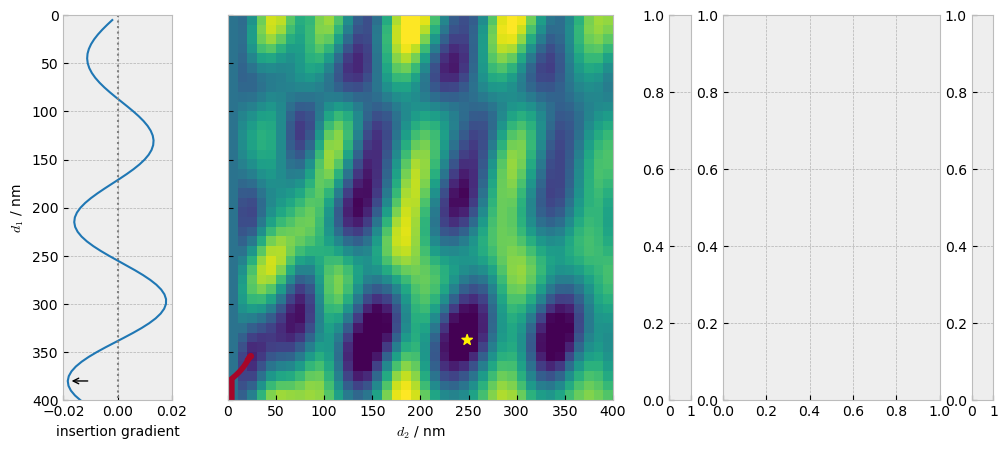

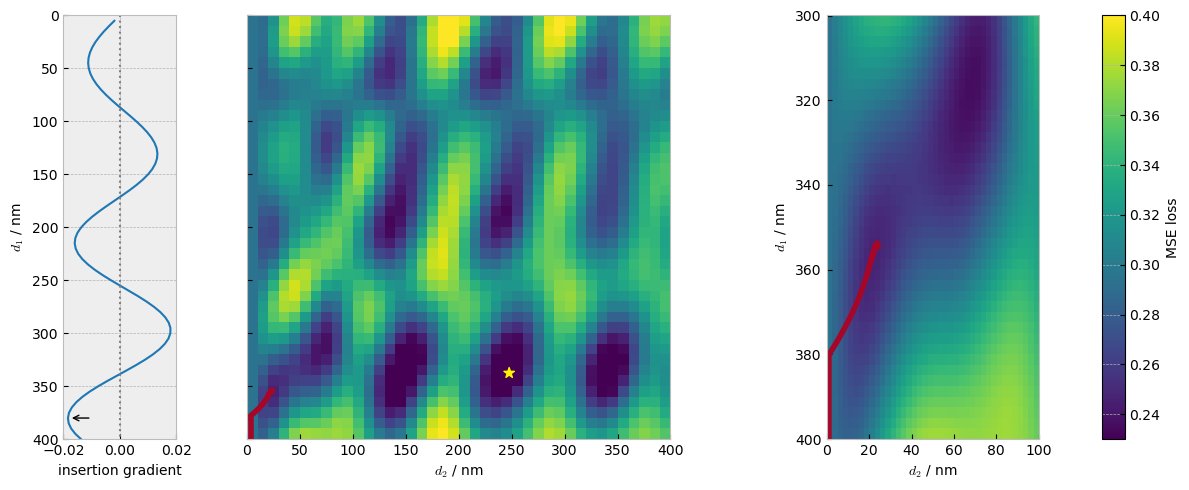

In [8]:

with plt.style.context('bmh'):
    fig, (ax_grad, ax, invisible_ax, ax_small, cax_2) = plt.subplots(1, 5, width_ratios=[0.5, 2, 0.1, 1, 0.1])
fig.set_size_inches(12, 5)

s1 = plot_large_range(ax_grad, ax, reuse_saved=True)
s2 = plot_small_range(ax_small, reuse_saved=True)
invisible_ax.set_visible(False)
cbar_2 = plt.colorbar(s2, cax=cax_2)
cbar_2.set_label('MSE loss')

fig.tight_layout()
fig.savefig('./search_space_res/reflection_2layers_needle_merge.png', dpi=500, bbox_inches='tight')

plt.show()